In [1]:
import pandas as pd
import numpy as np
import json
import requests

# real-time data

- google gtfs-realtime-bindings: https://developers.google.com/transit/gtfs-realtime/examples/python-sample
- gtfs.py: https://pypi.org/project/gtfs.py/
- pygtfs: https://pypi.org/project/pygtfs/
    https://pygtfs.readthedocs.io/en/latest/

- https://www.residentmar.io/2018/01/29/gtfs-tripify.html
- https://rstudio-pubs-static.s3.amazonaws.com/368765_99afb255f92341d5932e585a6889b83e.html

! pip install --upgrade gtfs-realtime-bindings

In [17]:
from google.transit import gtfs_realtime_pb2
import urllib.request

# url = 'http://datamine.mta.info/mta_esi.php?key=0a31860d17592bb141b8fe2052e64091&feed_id=26'
url = 'https://datamine-history.s3.amazonaws.com/gtfs-2014-09-17-09-31'
feed = gtfs_realtime_pb2.FeedMessage()
response = urllib.request.urlopen(url)
feed.ParseFromString(response.read())

204765

for entity in feed.entity:
    if entity.HasField('trip_update'):
        print(entity.trip_update)

In [18]:
feed.entity[0]

id: "000001"
trip_update {
  trip {
    trip_id: "050400_1..S02R"
    start_date: "20140917"
    route_id: "1"
  }
  stop_time_update {
    arrival {
      time: 1410960713
    }
    stop_id: "140S"
  }
}

In [19]:
feed.entity[1]

id: "000002"
vehicle {
  trip {
    trip_id: "050400_1..S02R"
    start_date: "20140917"
    route_id: "1"
  }
  current_stop_sequence: 38
  current_status: IN_TRANSIT_TO
  timestamp: 1410960574
  stop_id: "140S"
}

# historical GTFS-realtime

- AmazonAWS DATA: https://datamine-history.s3.amazonaws.com/index.html
    - http://datamine-history.s3.amazonaws.com/gtfs-2014-09-17.tgz
- Read local NTFS: https://stackoverflow.com/questions/38958751/parsing-nyc-transit-mta-historical-gtfs-data-not-realtime?answertab=votes#tab-top


! pip install pygtfs

In [ ]:
from google.transit import gtfs_realtime_pb2

## Integret all gtfs of a single day

In [40]:
def parsegtfs(gtfsFilePath):
    # This function parsegtfs overwrites the global dictionary named 'dict1'
    
    # read in gtfs
    f = open(gtfsFilePath, 'rb')
    raw_str = f.read()
    msg = gtfs_realtime_pb2.FeedMessage()
    msg.ParseFromString(raw_str)    

    # structure gtfs
    gtfs_timestamp = msg.header.timestamp
    for i,entity in enumerate(msg.entity):
        if entity.HasField('trip_update'):
            try:
                arrival_time = entity.trip_update.stop_time_update[0].arrival.time
                stop_id = entity.trip_update.stop_time_update[0].stop_id
                trip_id = entity.trip_update.trip.trip_id
                route_id = entity.trip_update.trip.route_id

                entity2 = msg.entity[i+1]
                current_stop_sequence = entity2.vehicle.current_stop_sequence
                current_status = entity2.vehicle.current_status
                vehicle_timestamp = entity2.vehicle.timestamp
                vehicle_stop_id = entity2.vehicle.stop_id       

                if current_stop_sequence >= 1:
                    try: # update record
                        if not gtfs_timestamp <= dict1[trip_id+ '//' + str(current_stop_sequence)]['gtfs_timestamp']:  
                            dict1[trip_id+ '//' + str(current_stop_sequence)] = \
                                {'gtfs_timestamp': gtfs_timestamp,
                                    'trip_id': trip_id,
                                    'arrival_time': arrival_time,
                                    'stop_id': stop_id,
                                    'route_id': route_id,
                                    'current_stop_sequence': current_stop_sequence,
                                    'current_status': current_status,
                                    'vehicle_timestamp': vehicle_timestamp,
                                    'vehicle_stop_id': vehicle_stop_id
                                }                    

                    except: # add new record
                        dict1[trip_id+ '//' + str(current_stop_sequence)] = \
                            {'gtfs_timestamp': gtfs_timestamp,
                                'trip_id': trip_id,
                                'arrival_time': arrival_time,
                                'stop_id': stop_id,
                                'route_id': route_id,
                                'current_stop_sequence': current_stop_sequence,
                                'current_status': current_status,
                                'vehicle_timestamp': vehicle_timestamp,
                                'vehicle_stop_id': vehicle_stop_id
                            }      
            except:
                continue

In [42]:
errornum = 0
import os
year, month, date = '2019', '06', '30'
FolderPath = year + month + date
gtfsFileNames = os.listdir(FolderPath)
dict1 = {}
for gtfsFileName in gtfsFileNames:
    gtfsFilePath = FolderPath + '/' + gtfsFileName
    try:
        parsegtfs(gtfsFilePath)
    except: # DecodeError: Error parsing message
        errornum+=1
        continue
print(errornum)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  


3


In [70]:
df = pd.DataFrame.from_dict(dict1).T

from datetime import datetime
df.arrival_time = df.arrival_time.apply(lambda x: datetime.fromtimestamp(x))
df.gtfs_timestamp = df.gtfs_timestamp.apply(lambda x: datetime.fromtimestamp(x))
df.vehicle_timestamp = df.vehicle_timestamp.apply(lambda x: datetime.fromtimestamp(x))

weekday_dict = {0:'Weekday', 1:'Weekday', 2:'Weekday', 3:'Weekday', 4:'Weekday', 5:'Saturday', 6:'Sunday'}
df['weekday'] = df.arrival_time.apply(lambda x: weekday_dict[x.weekday()])

df['trip_id2'] = df['weekday'] + '-' + df['trip_id']
df['match_id'] = df['trip_id2'] + '//' + df['current_stop_sequence'].astype(str)

print(df.shape)
df.head()

(81039, 12)


,arrival_time,current_status,current_stop_sequence,gtfs_timestamp,route_id,stop_id,trip_id,vehicle_stop_id,vehicle_timestamp,weekday,trip_id2,match_id
023580_7..N\13,2019-06-30 04:20:10,2,13,2019-06-30 04:20:25,7,711N,023580_7..N,711,2019-06-30 04:20:10,Sunday,Sunday-023580_7..N,Sunday-023580_7..N//13
023950_7..S\13,2019-06-30 04:21:13,2,13,2019-06-30 04:20:25,7,718S,023950_7..S,716,1969-12-31 19:00:00,Sunday,Sunday-023950_7..S,Sunday-023950_7..S//13
025685_7..N\2,2019-06-30 04:20:25,2,2,2019-06-30 04:20:45,7,724N,025685_7..N,724,2019-06-30 04:20:25,Sunday,Sunday-025685_7..N,Sunday-025685_7..N//2
023580_7..N\14,2019-06-30 04:21:30,2,14,2019-06-30 04:21:45,7,710N,023580_7..N,710,2019-06-30 04:21:30,Sunday,Sunday-023580_7..N,Sunday-023580_7..N//14
023950_7..S\14,2019-06-30 04:23:37,2,14,2019-06-30 04:22:45,7,719S,023950_7..S,718,1969-12-31 19:00:00,Sunday,Sunday-023950_7..S,Sunday-023950_7..S//14


## Schedules

In [108]:
stop_times = pd.read_csv("NYCSubwayGTFS9May2019/stop_times.txt")

stop_times['weekday'] = stop_times.trip_id.apply(lambda x: x.split('-')[-2]) # perfectly extracted
stop_times['weekday'] = stop_times['weekday'].apply(lambda x: 'Weekday' if x == 'Wednesday' else x) # L train does not have Weekday！ Only ['Saturday', 'Sunday', 'Wednesday']
stop_times['num_id'] = stop_times.trip_id.apply(lambda x: x.split('_')[1]) # perfectly extracted, fixed lenth
stop_times['direction'] = stop_times['trip_id'].apply(lambda x: x.split('-')[-1].split('.')[-1][0])
stop_times['route_id'] = stop_times['trip_id'].apply(lambda x: x.split('_')[-1].split('.')[0])

stop_times['trip_id2'] = stop_times['weekday'] + '-' + stop_times['num_id'] + '_' + stop_times['route_id'] + '..' + stop_times['direction']
stop_times['match_id'] = stop_times['trip_id2'] + '//' + stop_times['stop_sequence'].astype(str)

stop_times.drop(['departure_time', 'stop_headsign', 'pickup_type', 'drop_off_type', 'shape_dist_traveled'], axis=1, inplace=True)
stop_times.rename(columns={'arrival_time':'arrival_time_scheduled'}, inplace=True)

# conver timestamp
stop_times = stop_times[stop_times.arrival_time_scheduled.apply(lambda x: int(x[:2])<24)] # filter abnormal arrival_time which is greater than 24 hour
stop_times.arrival_time_scheduled = pd.to_datetime(stop_times.arrival_time_scheduled.apply(lambda x: year + '-' + month + '-' + date + '-' + x))

print(stop_times.shape)
stop_times.head()

(532330, 10)


,trip_id,arrival_time_scheduled,stop_id,stop_sequence,weekday,num_id,direction,route_id,trip_id2,match_id
0,ASP19GEN-1037-Sunday-00_000600_1..S03R,00:06:00,101S,1,Sunday,000600,S,1,Sunday-000600_1..S,Sunday-000600_1..S//1
1,ASP19GEN-1037-Sunday-00_000600_1..S03R,00:07:30,103S,2,Sunday,000600,S,1,Sunday-000600_1..S,Sunday-000600_1..S//2
2,ASP19GEN-1037-Sunday-00_000600_1..S03R,00:09:00,104S,3,Sunday,000600,S,1,Sunday-000600_1..S,Sunday-000600_1..S//3
3,ASP19GEN-1037-Sunday-00_000600_1..S03R,00:10:30,106S,4,Sunday,000600,S,1,Sunday-000600_1..S,Sunday-000600_1..S//4
4,ASP19GEN-1037-Sunday-00_000600_1..S03R,00:12:00,107S,5,Sunday,000600,S,1,Sunday-000600_1..S,Sunday-000600_1..S//5


In [239]:
# extracted data check
print(stop_times['weekday'].unique())
print(stop_times['direction'].unique())
print(stop_times['route_id'].unique())

['Sunday' 'Saturday' 'Weekday']
['S' 'N']
['1' '2' '3' '4' '5' '6' '7' 'GS' 'A' 'B' 'C' 'D' 'E' 'F' 'FS' 'H' 'J' 'M'
 'N' 'Q' 'R' 'G' 'L' 'SI']


In [247]:
# unique trip_id for weekday
print('All', len(stop_times.trip_id.unique()))
for i in stop_times['weekday'].unique():
    print(i, len(set(filter(lambda x: i in x, stop_times.trip_id))))

All 19842
Sunday 5403
Saturday 5995
Weekday 7940


In [241]:
# Sample rate
# It is expected to be 1 after adding the A-Division (Numeric trains)
3696/5403

0.6840644086618545

## Match schedule

In [77]:
print(len(set(df.trip_id2)))
print(len(set(stop_times.trip_id2).intersection(set(df.trip_id2))))
print('match rate:', len(set(stop_times.trip_id2).intersection(set(df.trip_id2)))/len(set(df.trip_id2)))

3724
1095
match rate: 0.29403866809881846


In [137]:
df_match = pd.merge(df, stop_times[['arrival_time_scheduled', 'match_id']], on='match_id', how='inner')
df_match['delay'] = (df_match['arrival_time'] - df_match['arrival_time_scheduled']).apply(lambda x: x.total_seconds())

print(df_match.shape)
df_match.head()

(19325, 14)


,arrival_time,current_status,current_stop_sequence,gtfs_timestamp,route_id,stop_id,trip_id,vehicle_stop_id,vehicle_timestamp,weekday,trip_id2,match_id,arrival_time_scheduled,delay
0,2019-06-30 04:24:25,2,1,2019-06-30 04:23:32,7,705S,026000_7..S,702,1969-12-31 19:00:00,Sunday,Sunday-026000_7..S,Sunday-026000_7..S//1,2019-06-30 04:20:00,265.0
1,2019-06-30 04:24:35,2,2,2019-06-30 04:24:45,7,705S,026000_7..S,705,2019-06-30 04:24:35,Sunday,Sunday-026000_7..S,Sunday-026000_7..S//2,2019-06-30 04:22:30,125.0
2,2019-06-30 04:25:50,2,3,2019-06-30 04:26:03,7,706S,026000_7..S,706,2019-06-30 04:25:50,Sunday,Sunday-026000_7..S,Sunday-026000_7..S//3,2019-06-30 04:24:00,110.0
3,2019-06-30 04:28:37,2,4,2019-06-30 04:27:45,7,708S,026000_7..S,707,1969-12-31 19:00:00,Sunday,Sunday-026000_7..S,Sunday-026000_7..S//4,2019-06-30 04:25:00,217.0
4,2019-06-30 04:28:40,2,5,2019-06-30 04:29:05,7,708S,026000_7..S,708,2019-06-30 04:28:40,Sunday,Sunday-026000_7..S,Sunday-026000_7..S//5,2019-06-30 04:26:00,160.0


## Analysis

### Average delay for all trains for all stations

In [139]:
df_match.delay.mean()

346.2032082794308

### Standard deviation of delays for all trains for all stations

In [146]:
df_match.delay.std()

414.9981425765837

### Delays for every route

In [140]:
df_match.groupby('route_id').mean()

,delay
route_id,
7,196.759362
A,432.565584
C,332.394175
D,272.450249
E,725.615303
F,721.924986
FS,226.400891
G,242.185491
H,275.418182


### Delays for every station


In [145]:
pd.merge(df_match.groupby('vehicle_stop_id').mean().reset_index(), stops, left_on='vehicle_stop_id', right_on='stop_id', how='left')[['delay', 'stop_id', 'stop_name', 'stop_lat', 'stop_lon']]

,delay,stop_id,stop_name,stop_lat,stop_lon
0,-93.871622,NaN,NaN,NaN,NaN
1,264.068182,701,Flushing - Main St,40.759600,-73.830030
2,401.822222,702,Mets - Willets Point,40.754622,-73.845625
3,304.583333,705,111 St,40.751730,-73.855334
4,127.700000,706,103 St - Corona Plaza,40.749865,-73.862700
5,140.405063,707,Junction Blvd,40.749145,-73.869527
6,134.897436,708,90 St - Elmhurst Av,40.748408,-73.876613
7,106.371795,709,82 St - Jackson Hts,40.747659,-73.883697
8,118.038462,710,74 St - Broadway,40.746848,-73.891394
9,136.320513,711,69 St,40.746325,-73.896403


Text(0.5, 1.0, 'MTA Subway Delay Stats for B-Division trains on 2019/6/30')

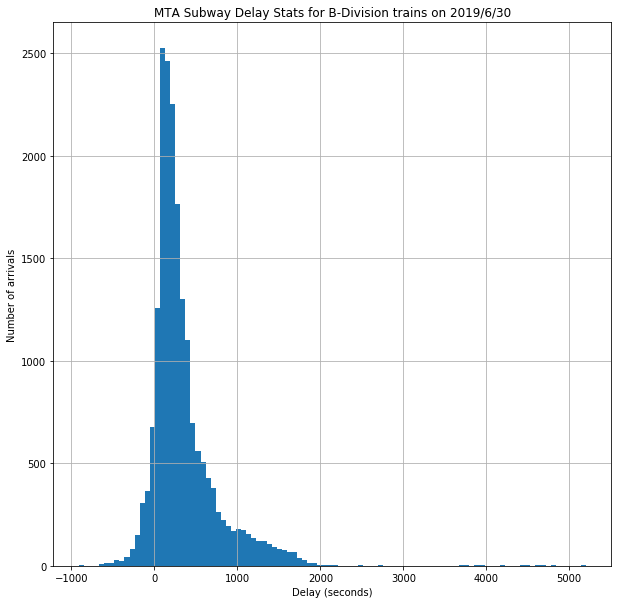

In [147]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
df_match.delay.hist(bins=100)
plt.xlabel('Delay (seconds)')
plt.ylabel('Number of arrivals')
plt.title('MTA Subway Delay Stats for B-Division trains on 2019/6/30')

### Average route delay for a single station

In [162]:
# take Atlantic as an example
Atlantic_stop_list = list(stops[stops.stop_name.apply(lambda x: 'Atlantic' in x)]['stop_id'])
df_match_Atlantic = df_match[df_match['stop_id'].isin(Atlantic_stop_list)]

In [164]:
df_match_Atlantic.groupby('route_id').mean()

,delay
route_id,
D,682.272727
L,43.545455
N,525.250000
Q,555.974576
R,588.481481
